In [1]:
import pandas as pd
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(1%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OSI/overlap_OSI(1%)_test.csv")

# Overlap ARDS
ARDS = pd.read_csv("~/project/MIMIC-III/ARDS.csv")
ARDS.drop("y", axis=1, inplace=True)

train_data = pd.merge(train_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
test_data = pd.merge(test_data, ARDS, on=['SUBJECT_ID', 'HADM_ID'], how='inner')


train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (2298, 55) 

train shape
 (1421, 55) 

train value
 0    1149
1    1149
Name: y, dtype: int64
test value
 0    1037
1     384
Name: y, dtype: int64


In [11]:
def objective(trial):
    c = trial.suggest_float("c", 1e-8, 10.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    
    model = SVC(C=c, kernel=kernel, probability=True, decision_function_shape="ovo", random_state=42)
    
    # Cross Validation을 통한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
    return scores.mean()

# 병렬 처리를 위해 n_jobs 대신 n_jobs=-1로 설정하고 Optuna 스터디 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, gc_after_trial=True, n_jobs=1)


[I 2023-09-06 14:59:37,577] A new study created in memory with name: no-name-581f205e-1421-4cc9-8126-f3025063ca32
[I 2023-09-06 14:59:41,013] Trial 0 finished with value: 0.4571689765316858 and parameters: {'c': 6.611532353849533e-08, 'kernel': 'rbf'}. Best is trial 0 with value: 0.4571689765316858.
[I 2023-09-06 14:59:43,619] Trial 1 finished with value: 0.6492427943331706 and parameters: {'c': 9.00000787285019e-05, 'kernel': 'linear'}. Best is trial 1 with value: 0.6492427943331706.
[I 2023-09-06 14:59:45,444] Trial 2 finished with value: 0.5120334119694155 and parameters: {'c': 1.2425876491228318e-06, 'kernel': 'linear'}. Best is trial 1 with value: 0.6492427943331706.


In [12]:
# 최적 하이퍼파라미터 확인
best_c = study.best_params["c"]
best_kernel = study.best_params["kernel"]

# 최적 모델 학습 및 평가
best_model = SVC(C=best_c, kernel=best_kernel, random_state=42)
best_model.fit(X_train, y_train)

SVC(C=9.00000787285019e-05, kernel='linear', random_state=42)

Test Accuracy: 61.58
Precision: 38.56
Recall: 71.09
F1-score: 50.0
AUROC: 64.57


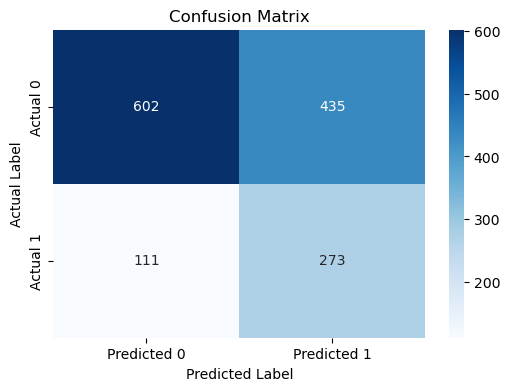

In [13]:
# Test 데이터로 모델 평가
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(test_data['y'], y_pred)
precision = precision_score(test_data['y'], y_pred)
recall = recall_score(test_data['y'], y_pred)
f1 = f1_score(test_data['y'], y_pred)
auroc = roc_auc_score(test_data['y'], y_pred)

rounded_accuracy = round(accuracy * 100, 2)
rounded_precision = round(precision * 100, 2)
rounded_recall = round(recall * 100, 2)
rounded_f1 = round(f1 * 100, 2)
rounded_auroc = round(auroc * 100, 2)

print("Test Accuracy:", rounded_accuracy)
print("Precision:", rounded_precision)
print("Recall:", rounded_recall)
print("F1-score:", rounded_f1)
print("AUROC:", rounded_auroc)

# Confusion Matrix 계산
cm = confusion_matrix(test_data['y'], y_pred)

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# # Classification Report 출력
# print("Classification Report:")
# print(classification_report(test_data['y'], y_pred))

# # Precision-Recall Curve 계산 및 시각화
# precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
# average_precision = auc(recall, precision)
# plt.figure()
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
# plt.show()

# # Feature Importance 계산
# feature_importance = best_model.feature_importances_

# # Feature Importance 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=feature_importance, y=features)
# plt.title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()